In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from collections import defaultdict
from functools import partial
import gc
from operator import add
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from htools import InvalidArgumentError
from incendio.core import BaseModel
from incendio.layers import JRelu, GRelu, mish

## Experimenting

Maybe skip connections could be useful for tabular data? Apparently usually not useful, maybe if network is very deep. Similar idea may be used here: https://arxiv.org/abs/1708.05123

In [ ]:
# class DenseLinear(BaseModel):
    
#     def __init__(self, x_dim, hidden_dim, activation=mish, skip_size=2):
#         super().__init__()
#         assert hidden_dim >= 2 ** (skip_size-1), ('Increase hidden dimension '
#                                                   'or decrease skip size.')
        
#         self.activation = activation
#         self.skip_size = skip_size
#         self.layers = nn.ModuleList([nn.Linear(x_dim, hidden_dim)])
        
#         prev_dim = hidden_dim
#         for i in range(1, skip_size):
#             new_dim = prev_dim // 2
#             new_layer = nn.Linear(prev_dim, new_dim)
#             self.layers.append(new_layer)
#             prev_dim = new_dim
            
#     def forward(self, x):
#         out = x
#         for i, layer in enumerate(self.layers):
#             out = layer(out)
#             if i != self.skip_size - 1:
#                 out = self.activation(out)
#         return self.activation(torch.cat((x, out), dim=1))

class DenseLinear(BaseModel):
    
    def __init__(self, x_dim, layer_dims, activation=mish):
        super().__init__()
        self.skip_size = len(layer_dims)
        self.activation = activation
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out
                                     in zip([x_dim]+list(layer_dims), layer_dims)])
            
    def forward(self, x):
        out = x
        for i, layer in enumerate(self.layers, 1):
            out = layer(out)
            if i < self.skip_size: out = self.activation(out)
        return self.activation(torch.cat((x, out), dim=1))

In [ ]:
def concat(*args, dim=-1):
    return torch.cat(args, dim=dim)

In [ ]:
class LinearSkipBlock(nn.Module):
    
    def __init__(self, x_dim, layer_dims, op, activation=mish):
        super().__init__()
        self.skip_size = len(layer_dims)
        self.activation = activation
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out
                                     in zip([x_dim]+list(layer_dims), layer_dims)])
        self.op = op
            
    def forward(self, x):
        out = x
        for i, layer in enumerate(self.layers, 1):
            out = layer(out)
            if i < self.skip_size: out = self.activation(out)
        print(self.op(x, out))
        return self.activation(self.op(x, out))

In [ ]:
# class ResLinear(BaseModel):
    
#     def __init__(self, x_dim, hidden_dims, activation=JRelu):
#         super().__init__()
#         self.skip_size = len(hidden_dims)
#         self.activation = activation
#         self.layers = nn.ModuleList([
#             nn.Linear(in_dim, out_dim) for in_dim, out_dim 
#             in zip([x_dim] + list(hidden_dims), list(hidden_dims) + [x_dim])
#         ])
    
#     def forward(self, x):
#         out = x
#         for i, layer in enumerate(self.layers):
#             out = layer(out)
#             if i != self.skip_size - 1:
#                 out = self.activation(out)
#         return self.activation(x + out)

class LinearResBlock(LinearSkipBlock):
    
    def __init__(self, x_dim, hidden_dims, activation=mish):
        if hidden_dims[-1] != x_dim:
            raise InvalidArgumentError(
                'Last hidden dimension must match input dimension.'
            )
        super().__init__(x_dim, hidden_dims, add, activation)

In [ ]:
class LinearDenseBlock(LinearSkipBlock):
    
    def __init__(self, x_dim, hidden_dims, activation=mish):
        super().__init__(x_dim, hidden_dims, concat, activation)

In [ ]:
x = torch.tensor([3, 5, 1])
i = [1]*2
x.view(-1, *i)

tensor([[[3]],

        [[5]],

        [[1]]])

In [ ]:
t1.ndim

2

In [ ]:
def weighted_avg(*args, weights):
    weights = torch.tensor(weights)
    total = weights.sum().float()
    if total != 1: weights = weights / total
    res = torch.stack(args)
    weights_shape = [-1 if i == 0 else 1 for i, _ in enumerate(range(res.ndim))]
    return torch.mean(res * weights.view(*weights_shape), axis=0)

In [ ]:
t1 = torch.arange(5).float()
t2 = torch.ones(5).float()
t3 = torch.randn(5).float()
print(t1, t2, t3)

tensor([0., 1., 2., 3., 4.]) tensor([1., 1., 1., 1., 1.]) tensor([-0.9681,  0.8185,  0.4446,  0.6494,  1.6390])


In [ ]:
weighted_avg(t1, t2,  t3, weights=[3, 5, 1])

tensor([[ 0.0000,  0.3333,  0.6667,  1.0000,  1.3333],
        [ 0.5556,  0.5556,  0.5556,  0.5556,  0.5556],
        [-0.1076,  0.0909,  0.0494,  0.0722,  0.1821]])


tensor([0.1493, 0.3266, 0.4239, 0.5426, 0.6903])

In [ ]:
t1 = torch.arange(6).view(3, 2).float()
t2 = torch.ones(3, 2).float()
t3 = torch.randn(3, 2).float()
print(t1, t2, t3, sep='\n')

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[-0.8853, -0.8809],
        [ 0.5187, -0.9115],
        [-1.2926,  0.5497]])


In [ ]:
weighted_avg(t1, t2,  t3, weights=[3, 5, 1])

tensor([[[ 0.0000,  0.3333],
         [ 0.6667,  1.0000],
         [ 1.3333,  1.6667]],

        [[ 0.5556,  0.5556],
         [ 0.5556,  0.5556],
         [ 0.5556,  0.5556]],

        [[-0.0984, -0.0979],
         [ 0.0576, -0.1013],
         [-0.1436,  0.0611]]])


tensor([[0.1524, 0.2637],
        [0.4266, 0.4848],
        [0.5818, 0.7611]])

In [ ]:
torch.tensor([[0.3333],
        [0.5556],
        [0.1111]]).shape
# * torch.tensor([[[ 0.0000,  1.0000],
#          [ 2.0000,  3.0000],
#          [ 4.0000,  5.0000]],

#         [[ 1.0000,  1.0000],
#          [ 1.0000,  1.0000],
#          [ 1.0000,  1.0000]],

#         [[-1.5408, -0.7166],
#          [ 0.6646,  0.2769],
#          [-0.3888,  0.1351]]])

torch.Size([3, 1])

In [ ]:
bs = 4
feature_dim = 6
hidden_dim = 16

model = LinearDenseBlock(feature_dim, [hidden_dim, 9, 3, 5])
x = torch.randint(5, size=(bs, feature_dim)).float()
x

tensor([[2., 2., 0., 0., 0., 4.],
        [4., 0., 3., 1., 1., 4.],
        [2., 4., 0., 1., 3., 4.],
        [2., 1., 0., 2., 0., 4.]])

In [ ]:
model

LinearDenseBlock(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=3, bias=True)
    (3): Linear(in_features=3, out_features=5, bias=True)
  )
)

In [ ]:
out = model(x)
print(out.shape)
out

tensor([[ 2.0000e+00,  2.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0000e+00, -1.7781e-01,  3.1595e-03,  2.1543e-01, -4.4647e-01,
         -4.8824e-01],
        [ 4.0000e+00,  0.0000e+00,  3.0000e+00,  1.0000e+00,  1.0000e+00,
          4.0000e+00, -1.7555e-01, -3.0404e-03,  2.7364e-01, -3.9930e-01,
         -4.9190e-01],
        [ 2.0000e+00,  4.0000e+00,  0.0000e+00,  1.0000e+00,  3.0000e+00,
          4.0000e+00, -2.3689e-01, -1.3044e-02,  2.6283e-01, -4.1826e-01,
         -4.2047e-01],
        [ 2.0000e+00,  1.0000e+00,  0.0000e+00,  2.0000e+00,  0.0000e+00,
          4.0000e+00, -2.0205e-01, -2.1700e-03,  2.3462e-01, -4.3416e-01,
         -4.6056e-01]], grad_fn=<CatBackward>)
torch.Size([4, 11])


tensor([[ 1.9440e+00,  1.9440e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          3.9974e+00, -9.6526e-02,  1.8989e-03,  1.4385e-01, -2.0443e-01,
         -2.1730e-01],
        [ 3.9974e+00,  0.0000e+00,  2.9865e+00,  8.6510e-01,  8.6510e-01,
          3.9974e+00, -9.5423e-02, -1.8213e-03,  1.8756e-01, -1.8867e-01,
         -2.1838e-01],
        [ 1.9440e+00,  3.9974e+00,  0.0000e+00,  8.6510e-01,  2.9865e+00,
          3.9974e+00, -1.2411e-01, -7.7718e-03,  1.7930e-01, -1.9516e-01,
         -1.9591e-01],
        [ 1.9440e+00,  8.6510e-01,  0.0000e+00,  1.9440e+00,  0.0000e+00,
          3.9974e+00, -1.0811e-01, -1.3005e-03,  1.5804e-01, -2.0044e-01,
         -2.0888e-01]], grad_fn=<MulBackward0>)

In [ ]:
model.trainable()

[((16, 6), True),
 ((16,), True),
 ((9, 16), True),
 ((9,), True),
 ((3, 9), True),
 ((3,), True),
 ((5, 3), True),
 ((5,), True)]

In [ ]:
model.dims()

[(16, 6), (16,), (8, 16), (8,)]

In [ ]:
x

tensor([[4., 0., 0., 1., 2., 2.],
        [4., 0., 1., 0., 2., 3.],
        [0., 3., 3., 0., 3., 1.],
        [2., 0., 4., 4., 0., 4.]])

In [ ]:
bs = 4
feature_dim = 6
hidden_dim = 16

model = ResLinear(feature_dim, [hidden_dim, 12])
x = torch.randint(5, size=(bs, feature_dim)).float()
x

tensor([[0., 4., 0., 4., 1., 3.],
        [1., 0., 2., 0., 0., 1.],
        [4., 0., 0., 3., 3., 3.],
        [2., 0., 0., 0., 4., 3.]])

In [ ]:
model

ResLinear(
  (activation): GReLU(leak=0.1, max=6.0, sub=0.4)
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=12, bias=True)
    (2): Linear(in_features=12, out_features=6, bias=True)
  )
)

In [ ]:
model(x).shape

torch.Size([4, 6])

In [ ]:
bs = 4
feature_dim = 6
hidden_dim = 16

model = LinearResBlock(feature_dim, [hidden_dim, hidden_dim//4])
x = torch.randint(5, size=(bs, feature_dim)).float()
x

tensor([[4., 2., 4., 1., 3., 0.],
        [4., 3., 4., 4., 0., 4.],
        [4., 1., 0., 3., 2., 3.],
        [1., 2., 1., 3., 0., 1.]])

In [ ]:
model

LinearResBlock(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=4, bias=True)
    (2): Linear(in_features=4, out_features=6, bias=True)
  )
)

In [ ]:
model(x).shape

tensor([[ 4.1386,  1.9666,  3.6655,  0.9114,  3.2314, -0.0582],
        [ 4.0349,  3.1004,  3.5271,  3.9476,  0.2363,  3.9812],
        [ 4.1243,  1.1191, -0.3778,  2.7918,  2.3451,  2.6615],
        [ 1.1321,  2.1452,  0.5129,  2.9463,  0.3553,  0.8902]],
       grad_fn=<AddBackward0>)


torch.Size([4, 6])

In [ ]:
bs = 4
feature_dim = 6
hidden_dim = 16

model = LinearResBlock(feature_dim, [feature_dim])
x = torch.randint(5, size=(bs, feature_dim)).float()
print(x)
model

tensor([[4., 2., 3., 1., 0., 0.],
        [2., 2., 3., 0., 4., 4.],
        [4., 0., 1., 2., 2., 0.],
        [2., 0., 1., 0., 0., 2.]])


LinearResBlock(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=6, bias=True)
  )
)

In [ ]:
model(x).shape

tensor([[ 4.5540,  1.9176,  3.6411,  0.9371, -1.8513, -1.2901],
        [ 3.8365,  1.4948,  1.5441, -1.9474,  2.3734,  2.9981],
        [ 4.3015,  0.4406, -0.1710,  2.4975,  0.8048, -0.8525],
        [ 2.2441,  1.1571,  0.2686, -0.5091, -0.8571,  1.4604]],
       grad_fn=<AddBackward0>)


torch.Size([4, 6])

## Dissecting model components

In [ ]:
from pprint import pprint

In [ ]:
class NestedModel(BaseModel):
    
    def __init__(self, c_in, hidden_dims):
        super().__init__(locals())
        self.fc = nn.Linear(c_in, hidden_dims[0])
        self.relu = nn.ReLU()
        linears = [nn.Linear(d0, d1) for d0, d1 in zip(hidden_dims, 
                                                       hidden_dims[1:])]
        linears = list(zip(linears, [nn.LeakyReLU() 
                                     for i in range(len(linears))]))
        self.seq = nn.Sequential(*[arg for pair in linears for arg in pair])
        self.mod = nn.ModuleList([nn.MaxPool1d(3), 
                                  nn.Linear(hidden_dims[-1]//3, 3)])
        
    def forward(self, x):
        x = self.relu(self.fc(x))
        x = self.seq(x).unsqueeze(1)
        print(x)
        for layer in self.mod:
            x = layer(x)
            print(x)
            if 'Linear' in str(type(layer)):
                x = F.softmax(x, dim=-1)
        return x

In [ ]:
x = torch.randint(10, (4, 6)).float()
print(x)

mod = NestedModel(6, [12, 10, 8, 6])
mod(x)

tensor([[0., 5., 2., 5., 9., 2.],
        [9., 0., 6., 3., 1., 3.],
        [2., 3., 9., 1., 2., 0.],
        [3., 3., 5., 9., 8., 5.]])
tensor([[[ 6.4326e-02,  3.1435e-02, -2.5885e-03,  3.9018e-01, -9.5811e-04,
           3.1741e-01]],

        [[-2.4429e-03,  5.3331e-02, -2.8642e-03,  5.5245e-01, -1.1792e-03,
           3.9474e-01]],

        [[-5.9604e-04,  1.5087e-01, -2.1209e-03,  3.9323e-01, -1.7153e-03,
           2.8635e-01]],

        [[-4.7646e-04,  9.2174e-02, -2.9102e-03,  4.3538e-01, -7.5166e-04,
           3.6905e-01]]], grad_fn=<UnsqueezeBackward0>)
tensor([[[0.0643, 0.3902]],

        [[0.0533, 0.5525]],

        [[0.1509, 0.3932]],

        [[0.0922, 0.4354]]], grad_fn=<SqueezeBackward1>)
tensor([[[-0.5289,  0.7264,  0.1837]],

        [[-0.5338,  0.7737,  0.1986]],

        [[-0.5653,  0.7254,  0.2313]],

        [[-0.5432,  0.7389,  0.2047]]], grad_fn=<AddBackward0>)


tensor([[[0.1527, 0.5359, 0.3114]],

        [[0.1476, 0.5455, 0.3069]],

        [[0.1459, 0.5304, 0.3236]],

        [[0.1489, 0.5366, 0.3145]]], grad_fn=<SoftmaxBackward>)

In [ ]:
mod

NestedModel(
  (fc): Linear(in_features=6, out_features=12, bias=True)
  (relu): ReLU()
  (seq): Sequential(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=6, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (mod): ModuleList(
    (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (1): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
# Gets list of all layers, extracting them from within modules and 
# sequentials. Don't think we typically need to do this though. 
layers = []
for c in mod.children():
    children = list(c.children())
    if not children:
        layers.append(c)
    else:
        layers.extend(children)

layers

[Linear(in_features=6, out_features=12, bias=True),
 ReLU(),
 Linear(in_features=12, out_features=10, bias=True),
 LeakyReLU(negative_slope=0.01),
 Linear(in_features=10, out_features=8, bias=True),
 LeakyReLU(negative_slope=0.01),
 Linear(in_features=8, out_features=6, bias=True),
 LeakyReLU(negative_slope=0.01),
 MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False),
 Linear(in_features=2, out_features=3, bias=True)]

In [ ]:
for c in mod.children():
    print([(p.shape, p.requires_grad) for p in c.parameters()])

[(torch.Size([12, 6]), True), (torch.Size([12]), True)]
[]
[(torch.Size([10, 12]), True), (torch.Size([10]), True), (torch.Size([8, 10]), True), (torch.Size([8]), True), (torch.Size([6, 8]), True), (torch.Size([6]), True)]
[(torch.Size([3, 2]), True), (torch.Size([3]), True)]


In [ ]:
# Model.parameters() seems to automatically iterate through each param in each
# child, same as in the cell above. Recurse=False oddly returns empty list?
[(p.shape, p.requires_grad) for p in mod.parameters(recurse=True)]

[(torch.Size([12, 6]), True),
 (torch.Size([12]), True),
 (torch.Size([10, 12]), True),
 (torch.Size([10]), True),
 (torch.Size([8, 10]), True),
 (torch.Size([8]), True),
 (torch.Size([6, 8]), True),
 (torch.Size([6]), True),
 (torch.Size([3, 2]), True),
 (torch.Size([3]), True)]

In [ ]:
pprint(list(mod.children()))

[Linear(in_features=6, out_features=12, bias=True),
 ReLU(),
 Sequential(
  (0): Linear(in_features=12, out_features=10, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=10, out_features=8, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=8, out_features=6, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
),
 ModuleList(
  (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (1): Linear(in_features=2, out_features=3, bias=True)
)]


In [ ]:
# Seems to start at high level and then dive deeper into model. So first item
# is whole model; then we get single layers, sequentials, and module lists; 
# then linear layers in the sequentials and module lists.
# Not sure when this would be useful.
pprint(list(mod.modules()))

[NestedModel(
  (fc): Linear(in_features=6, out_features=12, bias=True)
  (relu): ReLU()
  (seq): Sequential(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=6, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (mod): ModuleList(
    (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (1): Linear(in_features=2, out_features=3, bias=True)
  )
),
 Linear(in_features=6, out_features=12, bias=True),
 ReLU(),
 Sequential(
  (0): Linear(in_features=12, out_features=10, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=10, out_features=8, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=8, out_features=6, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
),
 Linear(in_features=12, out_features=10, bias=True),
 Lea

In [ ]:
# Also have named_parameters() which is almost identical, but each item is a
# tuple of name_str and weights.
pprint(dict(enumerate(mod.parameters())))

{0: Parameter containing:
tensor([[ 0.0099,  0.0274, -0.3193,  0.0329,  0.0444, -0.0355],
        [-0.1402,  0.0693, -0.2843,  0.1135,  0.2485, -0.3240],
        [ 0.3001,  0.2224,  0.3611, -0.2890, -0.1202,  0.2756],
        [ 0.2442, -0.2935,  0.3827, -0.1233,  0.0305,  0.3249],
        [-0.0148, -0.3202, -0.2059, -0.3465,  0.3627,  0.0037],
        [ 0.2162, -0.2803, -0.0667, -0.1019,  0.2888,  0.1954],
        [-0.1414,  0.0042, -0.2206,  0.3683, -0.1271,  0.3424],
        [ 0.3351, -0.0391, -0.0489,  0.0146,  0.3899, -0.1330],
        [ 0.1441,  0.3223, -0.2437,  0.2658, -0.3622, -0.2808],
        [-0.2277,  0.2159,  0.1413,  0.0822, -0.2127, -0.3655],
        [ 0.1330, -0.0927, -0.1883,  0.1051,  0.2737, -0.3455],
        [-0.3727, -0.3064,  0.1242,  0.2320,  0.1606, -0.3888]],
       requires_grad=True),
 1: Parameter containing:
tensor([-0.3684, -0.1282, -0.3694, -0.3890, -0.1481, -0.0204, -0.0075, -0.3795,
         0.0747, -0.3468, -0.3417,  0.3524], requires_grad=True),
 2: P

In [ ]:
mod

NestedModel(
  (fc): Linear(in_features=6, out_features=12, bias=True)
  (relu): ReLU()
  (seq): Sequential(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=6, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (mod): ModuleList(
    (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (1): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [ ]:
def freeze(x):
    for p in x.parameters(): 
        p.requires_grad = False

In [ ]:
for p in mod.parameters():
    p.requires_grad = True
    
pprint(mod.trainable())
mod.apply(freeze)
print()
pprint(mod.trainable())

[((12, 6), True),
 ((12,), True),
 ((10, 12), True),
 ((10,), True),
 ((8, 10), True),
 ((8,), True),
 ((6, 8), True),
 ((6,), True),
 ((3, 2), True),
 ((3,), True)]

[((12, 6), False),
 ((12,), False),
 ((10, 12), False),
 ((10,), False),
 ((8, 10), False),
 ((8,), False),
 ((6, 8), False),
 ((6,), False),
 ((3, 2), False),
 ((3,), False)]


In [ ]:
# Uses outputs of model.children()
mod.apply(lambda x: print('TYPE', type(x), list(x.parameters()), '\n'))

TYPE <class 'torch.nn.modules.linear.Linear'> [Parameter containing:
tensor([[-0.3656,  0.0783,  0.0917, -0.2374,  0.0969,  0.3274],
        [-0.3152,  0.1356,  0.3497, -0.0860, -0.3696, -0.2798],
        [-0.2190, -0.2395,  0.3667, -0.0832,  0.3711,  0.3256],
        [-0.3963,  0.1195,  0.0215,  0.1382, -0.1302,  0.3039],
        [ 0.2511,  0.3575,  0.1222,  0.3794, -0.3783, -0.1140],
        [ 0.1015,  0.1762,  0.2396,  0.0652,  0.2090,  0.0854],
        [ 0.0255,  0.3808, -0.0934, -0.1005,  0.2855,  0.0401],
        [-0.1884, -0.2917,  0.2465,  0.2880,  0.1670, -0.1933],
        [-0.1640,  0.2293,  0.1941,  0.3935,  0.2173, -0.0118],
        [ 0.3743, -0.3663, -0.2443,  0.1506, -0.2140,  0.3509],
        [-0.3813,  0.3435, -0.3736,  0.2517,  0.1702,  0.2703],
        [-0.0246, -0.2631, -0.0188,  0.2428, -0.2185, -0.2560]]), Parameter containing:
tensor([-0.2712,  0.3741,  0.0636,  0.1773, -0.1028, -0.2567, -0.3787,  0.1860,
        -0.0886, -0.1423,  0.1464, -0.0419])] 

TYPE <class

NestedModel(
  (fc): Linear(in_features=6, out_features=12, bias=True)
  (relu): ReLU()
  (seq): Sequential(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=6, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (mod): ModuleList(
    (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (1): Linear(in_features=2, out_features=3, bias=True)
  )
)

## More freezing: module list of sequentials

In [ ]:
class NestedSequentials(BaseModel):
    
    def __init__(self, x_dim, dims):
        super().__init__(locals())
        self.enc = nn.Sequential(nn.Linear(x_dim, dims[0]),
                                 nn.LeakyReLU(),
                                 nn.Linear(dims[0], dims[1]),
                                 nn.LeakyReLU())
        self.trans = nn.Sequential(nn.MaxPool1d(3),
                                   nn.ReLU(),
                                   nn.Linear(dims[1]//3, 4),
                                   nn.ReLU())
        self.dec = nn.Sequential(nn.Linear(4, 3),
                                 nn.Softmax(-1))
        self.blocks = nn.ModuleList([self.enc, self.trans, self.dec])
        
    def forward(self, x):
        for i, block in enumerate(self.blocks):
            if i == 1:
                x = x.unsqueeze(1)
            x = block(x)
        return x.squeeze(1)

In [ ]:
bs = 4
x_dim = 5
dims = [8, 6]

x = torch.randint(6, size=(bs, x_dim), dtype=torch.float)
print(x)
nested = NestedSequentials(x_dim, dims)
nested

tensor([[0., 2., 1., 2., 5.],
        [1., 1., 4., 3., 0.],
        [4., 5., 1., 1., 1.],
        [0., 5., 1., 1., 0.]])


NestedSequentials(
  (enc): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (trans): Sequential(
    (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=4, bias=True)
    (3): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): Softmax(dim=-1)
  )
  (blocks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=5, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=6, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=4, bias=True)
      (3): 

In [ ]:
nested._init_variables

{'x_dim': 5, 'dims': [8, 6]}

In [ ]:
nested(x)

tensor([[0.2564, 0.3047, 0.4389],
        [0.2811, 0.2976, 0.4213],
        [0.2688, 0.2922, 0.4390],
        [0.2694, 0.3175, 0.4131]], grad_fn=<SqueezeBackward1>)

In [ ]:
nested.weight_stats()

[(0.033, 0.282),
 (0.075, 0.213),
 (-0.004, 0.193),
 (0.078, 0.224),
 (0.178, 0.512),
 (0.041, 0.604),
 (-0.055, 0.213),
 (-0.19, 0.17)]

In [ ]:
for p in nested.parameters():
    p.requires_grad = False
    print(p.shape, p.requires_grad)
    p.requires_grad = True
    print(p.shape, p.requires_grad, '\n')

print('-'*20)
nested.apply(freeze)
for p in nested.parameters():
    print(p.shape, p.requires_grad)

torch.Size([8, 5]) False
torch.Size([8, 5]) True 

torch.Size([8]) False
torch.Size([8]) True 

torch.Size([6, 8]) False
torch.Size([6, 8]) True 

torch.Size([6]) False
torch.Size([6]) True 

torch.Size([4, 2]) False
torch.Size([4, 2]) True 

torch.Size([4]) False
torch.Size([4]) True 

torch.Size([3, 4]) False
torch.Size([3, 4]) True 

torch.Size([3]) False
torch.Size([3]) True 

--------------------
torch.Size([8, 5]) False
torch.Size([8]) False
torch.Size([6, 8]) False
torch.Size([6]) False
torch.Size([4, 2]) False
torch.Size([4]) False
torch.Size([3, 4]) False
torch.Size([3]) False


In [ ]:
nested.save(11)

Weights saved from epoch 11.


In [ ]:
model = NestedSequentials.from_path('data/model_11.pth')

Epoch 11 weights loaded from data/model_11.pth.
Model parameters: {'x_dim': 5, 'dims': [8, 6]}
Currently in eval mode.


In [ ]:
model(x)

tensor([[0.2564, 0.3047, 0.4389],
        [0.2811, 0.2976, 0.4213],
        [0.2688, 0.2922, 0.4390],
        [0.2694, 0.3175, 0.4131]], grad_fn=<SqueezeBackward1>)

In [ ]:
model.weight_stats()

[(0.033, 0.282),
 (0.075, 0.213),
 (-0.004, 0.193),
 (0.078, 0.224),
 (0.178, 0.512),
 (0.041, 0.604),
 (-0.055, 0.213),
 (-0.19, 0.17)]

In [ ]:
def variable_lr_optimizer(groups, lrs, optimizer=torch.optim.Adam, **kwargs):
    """Get an optimizer that uses different learning rates for different layer
    groups. Additional keyword arguments can be used to alter momentum and/or
    weight decay, for example, but for the sake of simplicity these values 
    will be the same across layer groups. 
    
    Parameters
    -----------
    groups: nn.ModuleList
        For this use case, the model should contain a ModuleList of layer 
        groups in the form of Sequential objects. This variable is then passed
        in so each group can receive its own learning rate.
    lrs: list[float]
        A list containing the learning rates to use for each layer group. This 
        should be the same length as the number of layer groups in the model.
        At times, we may want to use the same learning rate for all groups, 
        and can achieve this by passing in a list containing a single float.
    optimizer: torch optimizer
        The Torch optimizer to be created (Adam by default). 
        
    Examples
    ---------
    optim = variable_lr_optimizer(model.groups, [3e-3, 3e-2, 1e-1])
    """
    if len(lrs) == 1:
        lrs *= len(groups)
        
    data = [{'params': group.parameters(), 'lr': lr} 
            for group, lr in zip(groups, lrs)]
    return optimizer(data, **kwargs)

In [ ]:
variable_lr_optimizer(nested.blocks, [.5, .05, .005], weight_decay=.75)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.5
    weight_decay: 0.75

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.05
    weight_decay: 0.75

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0.75
)

In [ ]:
def save(self, epoch, dir_='data', file_pre='model', verbose=True, **kwargs):
    """Save model weights.
    
    Parameters
    -----------
    epoch: int
        The epoch of training the weights correspond to.
    dir_: str
        The directory which will contain the output file.
    file_pre: str
        The first part of the file name to save the weights to. The epoch
        and file extension will be added automatically.
    verbose: bool
        If True, print message to notify user that weights have been saved.
    **kwargs: any type
        User can optionally provide additional information to save 
        (e.g. optimizer state dict).
    """
    os.makedirs(dir_, exist_ok=True)
    file = f'{file_pre}_{epoch}.pth'
    path = os.path.join(dir_, file)
    
    data = dict(weights=self.state_dict(),
                epoch=epoch,
                params=self._init_variables)
    data = {**data, **kwargs}
    torch.save(data, path)
    
    if verbose:
        print(f'Weights saved from epoch {epoch}.')

In [ ]:
@classmethod
def from_path(cls, path, verbose=True):
    """Factory method to load a model from a file containing saved weights.
    
    Parameters
    -----------
    path: str
        File path to load weights from.
    verbose: bool
        If True, print message notifying user which weights have been loaded
        and what mode the model is in.
    """
    data = torch.load(path)
    model = cls(**data['params'])
    model.load_state_dict(data['weights'])
    model.eval()

    if verbose:
        print(f'Weights loaded from epoch {data["epoch"]}. '
              'Currently in eval mode.')
    return model

## Hooks

Related notes:  
-leaf variable - tensor defined by user (see x2 below)  
    -non-leaf - result of tensor operation (see y below)

In [ ]:
import matplotlib.pyplot as plt

from htools.ml import stats

In [ ]:
def hook_plot_gradients(grads):
    fig, ax = plt.subplots()
    ax.hist(grads.flatten().numpy())
    plt.show()

In [ ]:
def clip_gradients(grads):
    return torch.clamp(grads, -1000, 1000)

In [ ]:
def penalty(y):
    """Arbitrarily chosen."""
    return y.sum(-1).var()

In [ ]:
x2 = torch.randint(0, 10, (4, 8)).float()
x2

tensor([[8., 4., 5., 7., 4., 8., 2., 3.],
        [2., 0., 1., 8., 7., 5., 3., 9.],
        [2., 4., 3., 9., 2., 0., 6., 0.],
        [6., 1., 3., 0., 4., 0., 5., 5.]])

In [ ]:
w = torch.randn((8, 2), requires_grad=True)
w.register_hook(hook_plot_gradients)
w

tensor([[-0.9228,  1.0944],
        [ 0.7592,  0.1647],
        [-1.0077,  0.5434],
        [ 1.0515, -0.9802],
        [-0.1555, -0.0869],
        [-1.1046,  1.9011],
        [-1.2100, -1.3748],
        [ 0.3485,  0.4592]], requires_grad=True)

In [ ]:
y = x2 @ w
cost = penalty(y)
cost

tensor(79.9269, grad_fn=<VarBackward0>)

In [ ]:
w.grad

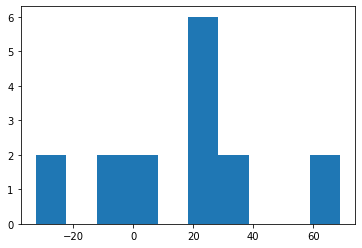

In [ ]:
cost.backward()

In [ ]:
w.grad

tensor([[ 21.9028,  21.9028],
        [ -3.5688,  -3.5688],
        [  4.8685,   4.8685],
        [ 18.6997,  18.6997],
        [ 23.7503,  23.7503],
        [ 68.9819,  68.9819],
        [-32.5070, -32.5070],
        [ 33.5617,  33.5617]])

In [ ]:
def train(hooks, iters=5, lr=.1):
    x = torch.randint(6, (4, 128), dtype=torch.float)
    w = torch.randn((128, 2), requires_grad=True)

#     w.register_hook(hook_plot_gradients)
#     w.register_hook(lambda x: print(stats(x)))
    for hook in hooks:
        w.register_hook(hook)

    for i in range(iters):
        if w.grad is not None: w.grad.zero_()
        y = x @ w
        cost = penalty(y)
        cost.backward()
        with torch.no_grad():
            w -= lr * w.grad

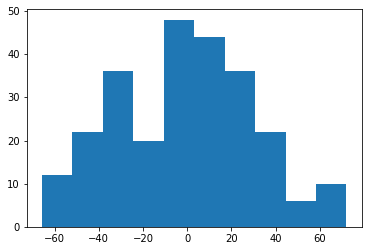

(-0.8818, 31.2236)
tensor(-0.8818) tensor(31.2236)


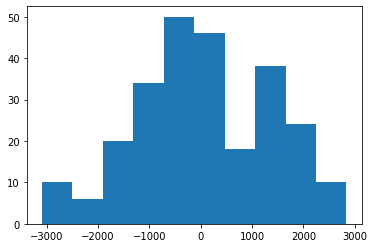

(33.1751, 1318.7448)
tensor(6.9012) tensor(798.8826)


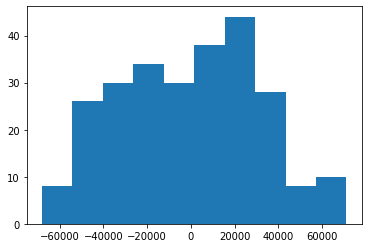

(-193.5696, 31778.0195)
tensor(43.3803) tensor(998.2910)


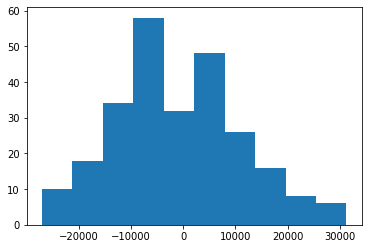

(-1093.7861, 11979.1465)
tensor(-104.1612) tensor(982.8121)


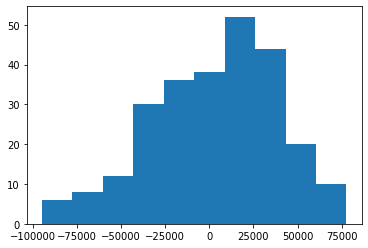

(3164.0146, 35859.3125)
tensor(81.5004) tensor(991.8568)


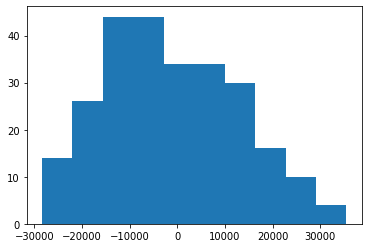

(-1254.1228, 13872.3652)
tensor(-105.7121) tensor(984.0605)


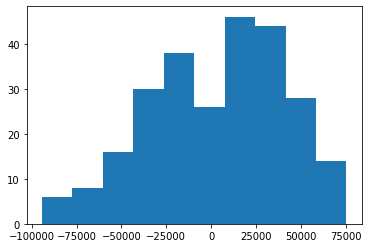

(3300.1748, 37887.875)
tensor(83.0058) tensor(991.3549)


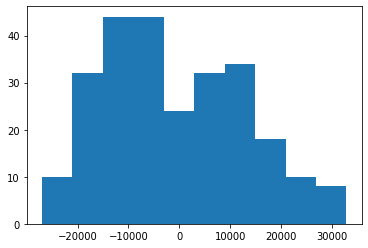

(-1059.9579, 14192.6484)
tensor(-82.3730) tensor(986.9633)


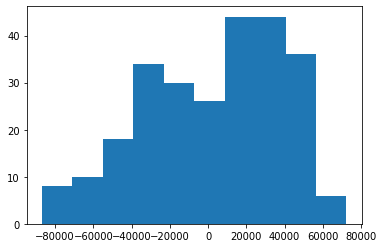

(2753.9849, 37713.6133)
tensor(80.4163) tensor(996.7465)


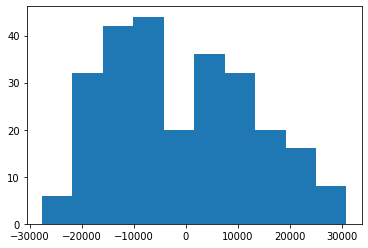

(-934.8754, 14230.0137)
tensor(-98.5673) tensor(985.5751)


In [ ]:
hooks = [hook_plot_gradients, 
         lambda x: print(stats(x)),
         clip_gradients,
         lambda x: print(torch.mean(x), torch.std(x))]

train(hooks, 10)

In [ ]:
x.is_leaf

True

In [ ]:
y.is_leaf

False

In [ ]:
model

NameError: name 'model' is not defined